# Laboratoire 6
## Filtre de Kalman

### Partie 1 - Calibration du capteur

In [2]:
# Importation des modules

%load_ext autoreload
%autoreload 2
%matplotlib inline

import os.path
import numpy as np
import matplotlib.pyplot as plt
from robmob.robot import Robot
from robmob.sensors import SharpSensor
from IPython.display import clear_output

Modifiez la valeur de `ip_robot` selon le robot qui vous a été assigné.

In [1]:
# Connexion au robot
ip_robot = '192.168.0.114'
robot = Robot(ip_robot)
robot.connect()

NameError: name 'Robot' is not defined

In [ ]:
sharp_sensor_id = 0 # 0 ou 1 selon votre robot
sharp_sensor = SharpSensor(sharp_sensor_id)
robot.add_sensor(sharp_sensor)

Utilisez cette cellule pour vérifier que vous avez bien choisis le bon capeut IR

In [ ]:
data = sharp_sensor.read_buffer()
print(data)
print("La lecture moyenne est de %0.2f volts" % np.average(data))

#### Calibration
Prenez une série de mesures séparées de 5 cm, entre 30 cm et 120 cm. Prenez note que le buffer prend environ 2 secondes à ce remplir, donc prenez votre temps entre les mesurese.
Soyez attentifs, car ces mesures
serviront à calibrer votre capteur infrarouge et aussi à tester votre filtre de Kalman.

Dans la cellule suivante, utilisez ```t``` (take) pour prendre la mesure et ```r``` (retry) pour reprendre la mesure. 

In [ ]:
xs = np.array([x for x in range(0.30, 1.25, 0.05)]) * 0.01 #Distances à calibrer en mètres
zs = []

In [ ]:
# Capture des données de calibration

for x in xs:
    key_in = ''
    while key_in != 't':
        buf = sharp_sensor.read_buffer()
        z = np.mean(buf)
        print("moyenne de %d mesures: %f" % (len(buf), z))
        print("(t)ake / (r)etry")
    zs.append(z)
    clear_output()

zs = np.asarray(zs)

In [ ]:
# Sauvegarde des zs de calibration sur le disque (au cas où vous redémarriez le notebook)
np.savetxt("./lab6_calib_zs.txt", zs)

In [ ]:
zs = np.loadtxt("./lab6_calib_zs.txt")

In [19]:
def calibrate(xs, zs):
    """
    Args:
      - xs: distances en mètres des mesures zs
      - zs: mesures en Volts
    Return:
      - Fonction linéaire qui prend en entrée l'inverse de la distance en mètres et retourne une mesure en Volts 
        (c'est la fonction de capteur)
      - Les coefficients de K_1 et K_2 de la fonction linéaire de capteur
    """
    xs_inverse_meters = 1.0 / xs
    coeffs = np.polyfit(xs_inverse_meters, zs, deg=1)
    sensor_function = np.poly1d(coeffs)
    return sensor_function, coeffs

In [30]:
#TODO remove this (only there to test the plot)
xs = np.array([x for x in range(30, 125, 5)]) * 0.01
zs = np.asarray([2, 1.52, 1.2, 1.11, 1.05, 1, 0.96, 0.88, 0.79, 0.75, 0.71, 0.65, 0.64, 0.62, 0.59, 0.57, 0.52, 0.5, 0.47])
xs.shape == zs.shape

True

K_1: 0.033304
K_2: 0.532526


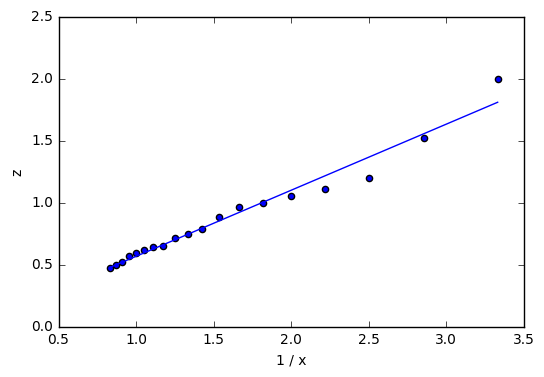

In [29]:
sensor_fn, coeffs = calibrate(xs, zs)
print("K_1: %f" % coeffs[1])
print("K_2: %f" % coeffs[0])

#Plot calibration
xs_inv = 1.0 / xs
plt.scatter(xs_inv, zs)
plt.plot(xs_inv, sensor_fn(xs_inv))
plt.xlabel("1 / x")
plt.ylabel("z")


## TODO insérer l'image
Comme illustré à l’image ci-haut, le capteur infrarouge fonctionne essentiellement avec l’inverse de la
distance. Il sera donc approximé par la fonction suivante :

$$
f_{infrarouge}(x) = K_{1 Sharp} + \frac{K_{2 Sharp}}{x}, x > 30
$$

Comme cette fonction est
bijective, on peut trouver un estimé de distance $x$ directement à partir de la mesure infrarouge $z$, avec
l’inverse de la fonction :

$$
f^{-1}_{infrarouge}(z) = \frac{K_{2 Sharp}}{z - K_{1 Sharp}}
$$

Vous aurez besoin de cette fonction pour initialiser l’estimé $X$ d’un filtre quand vous ne connaissez pas
la position de départ du système. Elle sera aussi utilisée par le script pour comparer directement les
mesures du capteur infrarouge avec vos estimés. **Notez que ces équations (1) et (2) ne sont valides que
pour $x$ > 0.30 m : votre robot ne pourra donc jamais être à moins de 0.30 m du mur**.

### Partie 2 - Modèle du système
Comme estimé de bruit sur le capteur infrarouge, nous allons prendre la valeur de $\sigma^2_{infrarouge} = (0.02V)^2$, ce qui correspond approximativement à un palier du convertisseur analogique-numérique. Le bruit de
déplacement sera $\sigma^2_{pas} = (0.002 m)^2$, ce qui donne essentiellement un écart-type de 2 mm sur un pas du
robot. Fait à noter, le choix de ces valeurs influencera grandement le comportement du filtre. Ainsi, si
vous choisissez un estimé de bruit de capteur $\sigma^2_{infrarouge}$
plus petit, vous indiquez au filtre qu’il doit
augmenter sa confiance envers les mesures du capteur. De la même manière, si vous diminuez la valeur
estimée du bruit sur les commandes $\sigma^2_{pas}$, il augmentera sa confiance envers l’estimé $x(k+1\,|\,k)$ obtenu lors
de la phase de prédiction. Nous y reviendrons lors des manipulations.

La dynamique du système et la commande sont linéaires pour ce système:

$$
x(k + 1\,|\,k) = x(k) + u(k)
$$

> **NOTE** Le bruit associé à la conversion analogique-numérique est généralement modélisé comme une distribution uniforme entre
±un demi-palier de conversion. Pour les curieux, une discussion complète de ce sujet est disponible sur wikipedia :
http://en.wikipedia.org/wiki/Quantization_error